In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from numpy import ndarray

from maf.core import PositionState, SpaceLimit
from maf import persistence, field_modulation

np.random.seed(24)

/home/samanu/Desktop/Master/Year2/Thesis/multi_agent_framework/maf/data


In [3]:
def load_experiment_data(experiment_dir: str, logger: str) -> list[dict]:
    data: list[dict] = []
    for log_file in persistence.list_files(experiment_dir, logger):
        data.append(persistence.load(experiment_dir, logger, log_file))
    return data

## PositionLogger

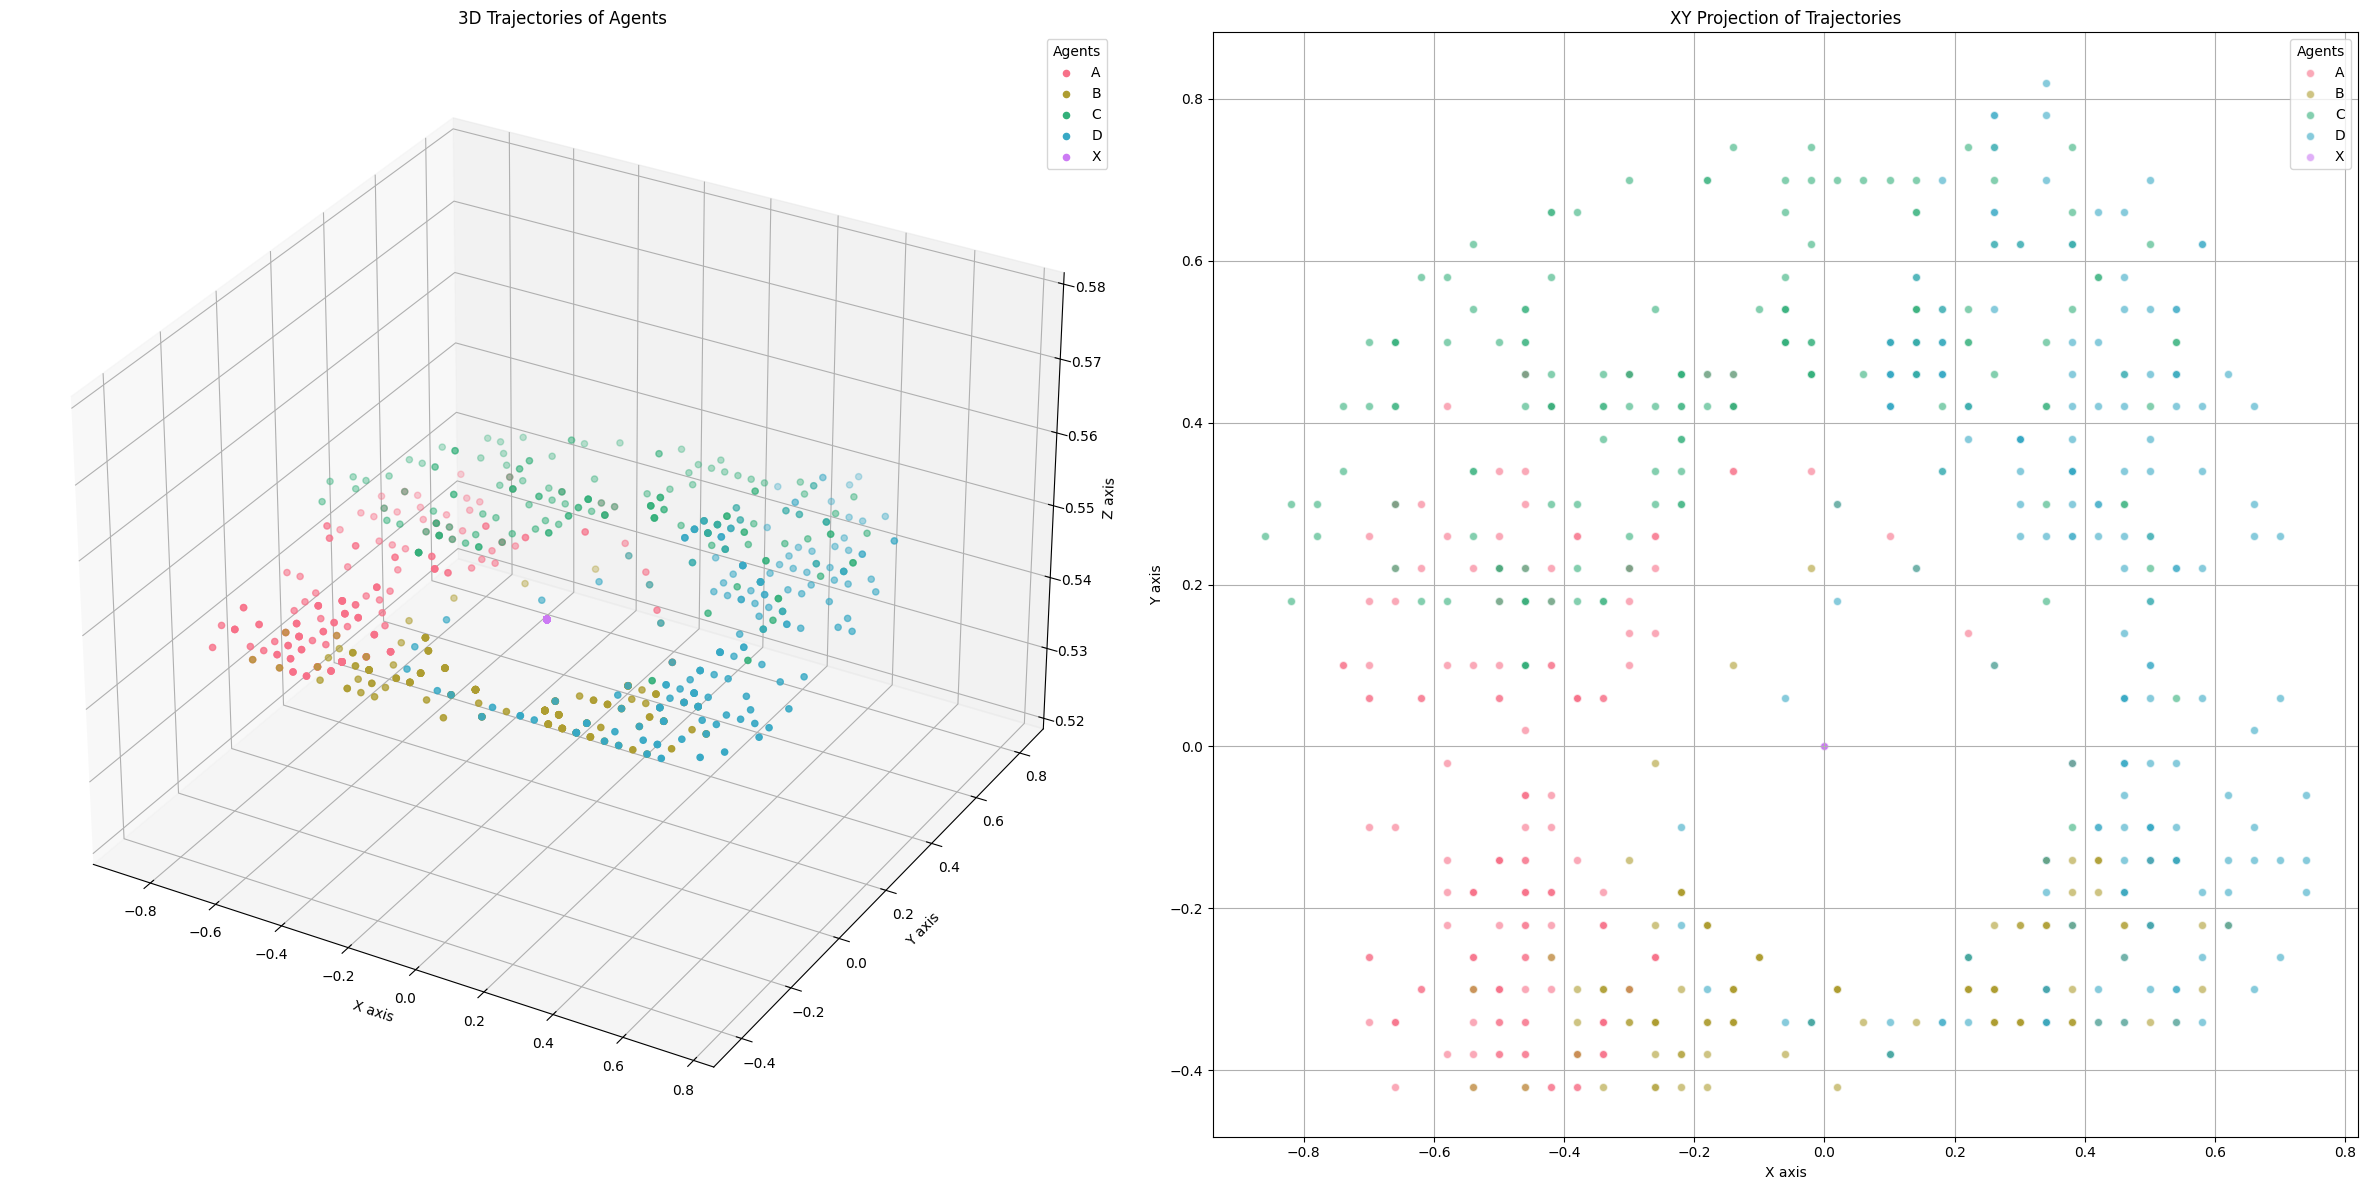

In [9]:
def generate_colors(df: pd.DataFrame) -> dict[str, ndarray]:
    unique_agents: list[str] = df["agent"].unique()
    # Use seaborn color palette
    palette = sns.color_palette("husl", len(unique_agents))
    colors: dict[str, ndarray] = {
        agent: palette[i] for i, agent in enumerate(sorted(unique_agents))
    }
    return colors


def plot_3d_trajectories(ax, df: pd.DataFrame, colors: dict[str, ndarray]):
    assert set(df.columns) == {"agent", "X", "Y", "Z"}, "Invalid df provided"

    for agent, group in df.groupby("agent"):
        ax.scatter(group["X"], group["Y"], group["Z"], color=colors[agent], label=agent)

    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("3D Trajectories of Agents")
    ax.legend(title="Agents")


def scatter_xy_trajectories(ax, df: pd.DataFrame, colors: dict[str, ndarray]):
    assert set(df.columns) == {"agent", "X", "Y", "Z"}, "Invalid df provided"

    for agent, group in df.groupby("agent"):
        ax.scatter(
            group["X"],
            group["Y"],
            color=colors[agent],
            label=agent,
            alpha=0.6,
            edgecolors="w",
        )

    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title("XY Projection of Trajectories")
    ax.legend(title="Agents")
    ax.grid(True)


def plot_trajectories(df: pd.DataFrame):
    colors = generate_colors(df)

    fig = plt.figure(figsize=(24, 12))

    # Create 3D subplot
    ax1 = fig.add_subplot(121, projection="3d")
    plot_3d_trajectories(ax1, df, colors)

    # Create 2D subplot for XY plane
    ax2 = fig.add_subplot(122)
    scatter_xy_trajectories(ax2, df, colors)

    plt.tight_layout()
    plt.show()


def plot_experiment_trajectories(experiment: str):
    processed_data: list[dict] = []
    for data_log in load_experiment_data(experiment, "PositionLogger"):
        state: PositionState = data_log["state"]
        processed_data.append(
            {
                "agent": data_log["agent"],
                "X": state.position.x,
                "Y": state.position.y,
                "Z": state.position.z,
            }
        )

    df: pd.DataFrame = pd.DataFrame(
        processed_data, columns=["agent", "X", "Y", "Z"]
    ).fillna(0)
    plot_trajectories(df)

plot_experiment_trajectories('default')

## Field modulation

In [5]:
VICINITY_LIMIT = [1.5, 1.5]
FIELD_SIZE = [84, 84]
SPACE_LIMIT = SpaceLimit(x_min=-2.5, x_max=1.5, y_min=-1.0, y_max=2.0)


def plot_field_modulation_scenario(
    points: np.array,
    center: list[float],
    neighbours: np.array,
    field: np.array,
    zoomed_field: np.array,
):
    # Plotting
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Plot the original points and the chosen point
    ax[0, 0].scatter(
        points[:, 0], points[:, 1], color="gray", alpha=0.5, label="Points"
    )
    ax[0, 0].scatter(
        neighbours[:, 0], neighbours[:, 1], color="blue", label="Neighbors"
    )
    ax[0, 0].add_patch(
        plt.Rectangle(
            (SPACE_LIMIT.x_min, SPACE_LIMIT.y_min),
            SPACE_LIMIT.x_max - SPACE_LIMIT.x_min,
            SPACE_LIMIT.y_max - SPACE_LIMIT.y_min,
            linewidth=1,
            edgecolor="black",
            facecolor="none",
        )
    )

    ax[0, 0].scatter(center[0], center[1], color="red", label="Chosen Point")
    ax[0, 0].axhline(0, color="black", linewidth=0.5)
    ax[0, 0].axvline(0, color="black", linewidth=0.5)
    ax[0, 0].set_xlim(-5, 5)
    ax[0, 0].set_ylim(-5, 5)
    ax[0, 0].legend()
    ax[0, 0].set_xlabel("X-axis")
    ax[0, 0].set_ylabel("Y-axis")
    ax[0, 0].set_title("Original Points with Neighborhood")

    relative_center_x, relative_center_y = field_modulation.to_field_position(
        center, center, FIELD_SIZE, VICINITY_LIMIT
    )

    # Plot the tensor with Gaussian effects
    ax[0, 1].imshow(field, cmap="Greys", origin="lower")
    ax[0, 1].scatter(
        relative_center_x, relative_center_y, color="red", label="Chosen Point"
    )
    ax[0, 1].axhline(relative_center_y, color="black", linewidth=0.5)
    ax[0, 1].axvline(relative_center_x, color="black", linewidth=0.5)
    ax[0, 1].set_xlabel("X-axis")
    ax[0, 1].set_ylabel("Y-axis")
    ax[0, 1].set_title("Tensor with Gaussian Effects")
    ax[0, 1].legend()

    # Plot the clipped and rescaled tensor
    ax[1, 0].imshow(zoomed_field, cmap="Greys", origin="lower")
    ax[1, 0].scatter(
        relative_center_x, relative_center_y, color="red", label="Chosen Point"
    )
    ax[1, 0].axhline(relative_center_y, color="black", linewidth=0.5)
    ax[1, 0].axvline(relative_center_x, color="black", linewidth=0.5)
    ax[1, 0].set_xlabel("X-axis")
    ax[1, 0].set_ylabel("Y-axis")
    ax[1, 0].set_title("Clipped and Rescaled Tensor")
    ax[1, 0].legend()

    # Plot the 3D surface plot
    ax_3d = fig.add_subplot(
        2,
        2,
        4,
        projection="3d",
    )

    # Generate x and y coordinates
    x = np.arange(FIELD_SIZE[0])
    y = np.arange(FIELD_SIZE[1])
    x, y = np.meshgrid(x, y)

    # Plot the surface
    ax_3d.plot_surface(x, y, zoomed_field, cmap="viridis")
    ax_3d.view_init(elev=30, azim=-120)

    # Set labels
    ax_3d.set_xlabel("X-axis")
    ax_3d.set_ylabel("Y-axis")
    ax_3d.set_zlabel("Z-axis")

    # Show the plots
    plt.tight_layout()
    plt.show()


def plot_field_with_divisions(arr, ax):
    ax.imshow(arr, cmap="viridis", interpolation="none", origin="lower")
    ax.set_title("Field divided in 9 parts")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")

    nrows, ncols = arr.shape
    row_step = nrows // 3
    col_step = ncols // 3

    for i in range(1, 3):
        ax.axhline(i * row_step - 0.5, color="red", linewidth=2)
        ax.axvline(i * col_step - 0.5, color="red", linewidth=2)


def plot_rewards(results, ax):
    cax = ax.imshow(
        results,
        cmap="viridis",
        interpolation="none",
        vmin=np.min(results),
        vmax=np.max(results),
        origin="lower",
    )
    ax.set_title("Results of Reward Function on field divisions")

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")

    # Remove the numbers on the axis
    ax.set_xticks([])
    ax.set_yticks([])

    for (i, j), val in np.ndenumerate(results):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="white")

    plt.colorbar(cax, ax=ax)


def run_hill_climbing(field: np.array):
    field_divisions: np.array = field_modulation.pooling_to_3x3(field, "sum")

    # 1x2 grid
    _, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Divisions
    plot_field_with_divisions(field, axes[0])

    # Rewards
    plot_rewards(field_divisions, axes[1])

    plt.tight_layout()
    plt.show()
    print("field_divisions", field_divisions)


def run_field_modulation_scenario(points: np.array, center: list[float]):
    neighbours: np.array = field_modulation.filter_points_in_vicinity(
        points, center, VICINITY_LIMIT
    )
    modulations: np.array = np.array([])

    field: np.array = np.zeros(FIELD_SIZE)
    for neighbour in neighbours:
        relative_neighbour_field_pos = field_modulation.to_field_position(
            neighbour, center, FIELD_SIZE, VICINITY_LIMIT
        )
        field = field_modulation.apply_distribution(
            field,
            relative_neighbour_field_pos,
            space_factor=1,
            amplitude=1,
            operation="subtract",
        )

    field_limited = field_modulation.patch_value_outside_vicinity_limit(
        field=field,
        center=center,
        space_limit=SPACE_LIMIT,
        vicinity_limit=VICINITY_LIMIT,
        field_size=FIELD_SIZE,
    )

    field_limited_zoomed = field_modulation.clip_and_resize(
        field=field_limited, field_size=FIELD_SIZE, clip_size_factor=2
    )

    plot_field_modulation_scenario(
        points=points,
        center=center,
        neighbours=neighbours,
        field=field_limited,
        zoomed_field=field_limited_zoomed,
    )

    run_hill_climbing(field_limited_zoomed)

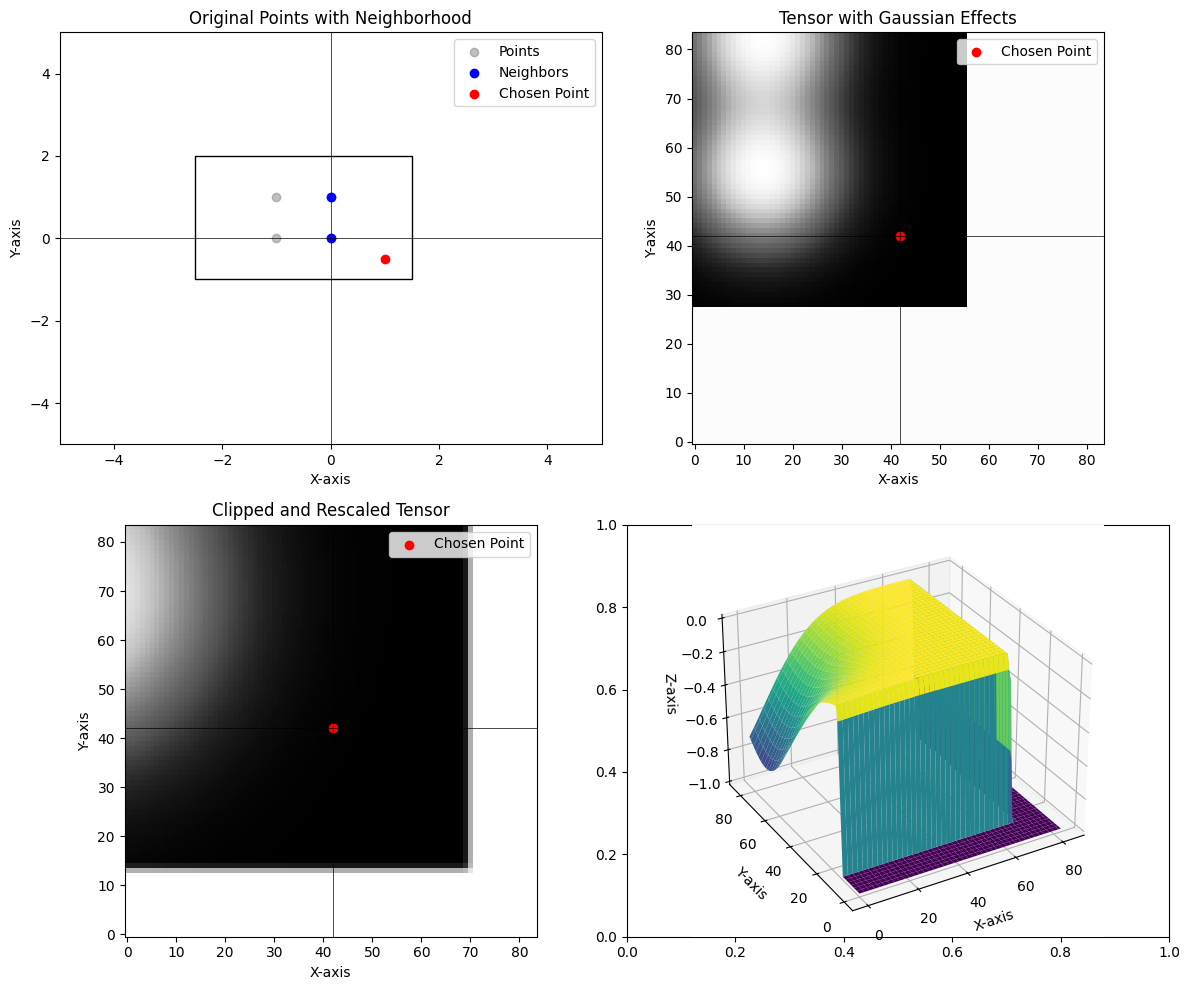

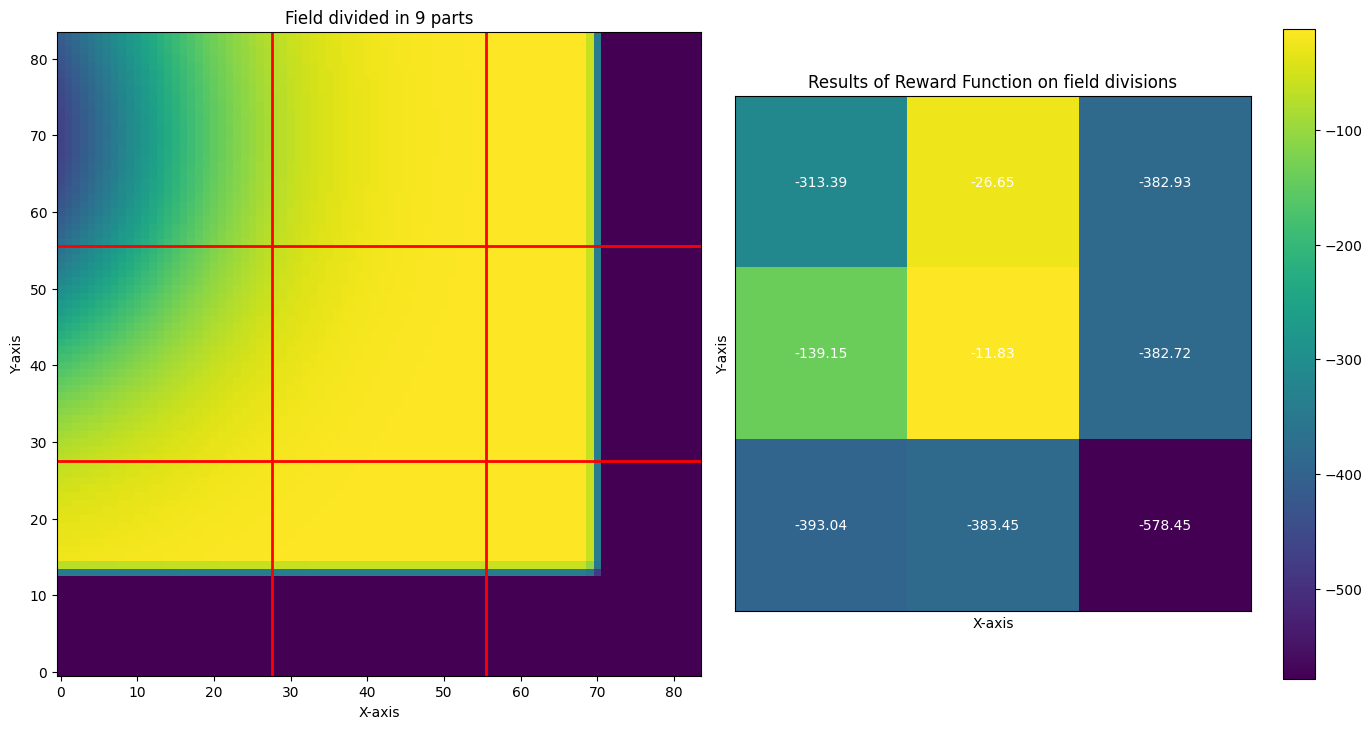

field_divisions [[-393.04115913 -383.44593924 -578.45297182]
 [-139.15210539  -11.83233797 -382.72087088]
 [-313.38866965  -26.64796658 -382.92954341]]


In [6]:
run_field_modulation_scenario(
    points=np.array([[-1, 1], [0, 1], [0, 0], [-1, 0]]),
    center=[1, -0.5]
)

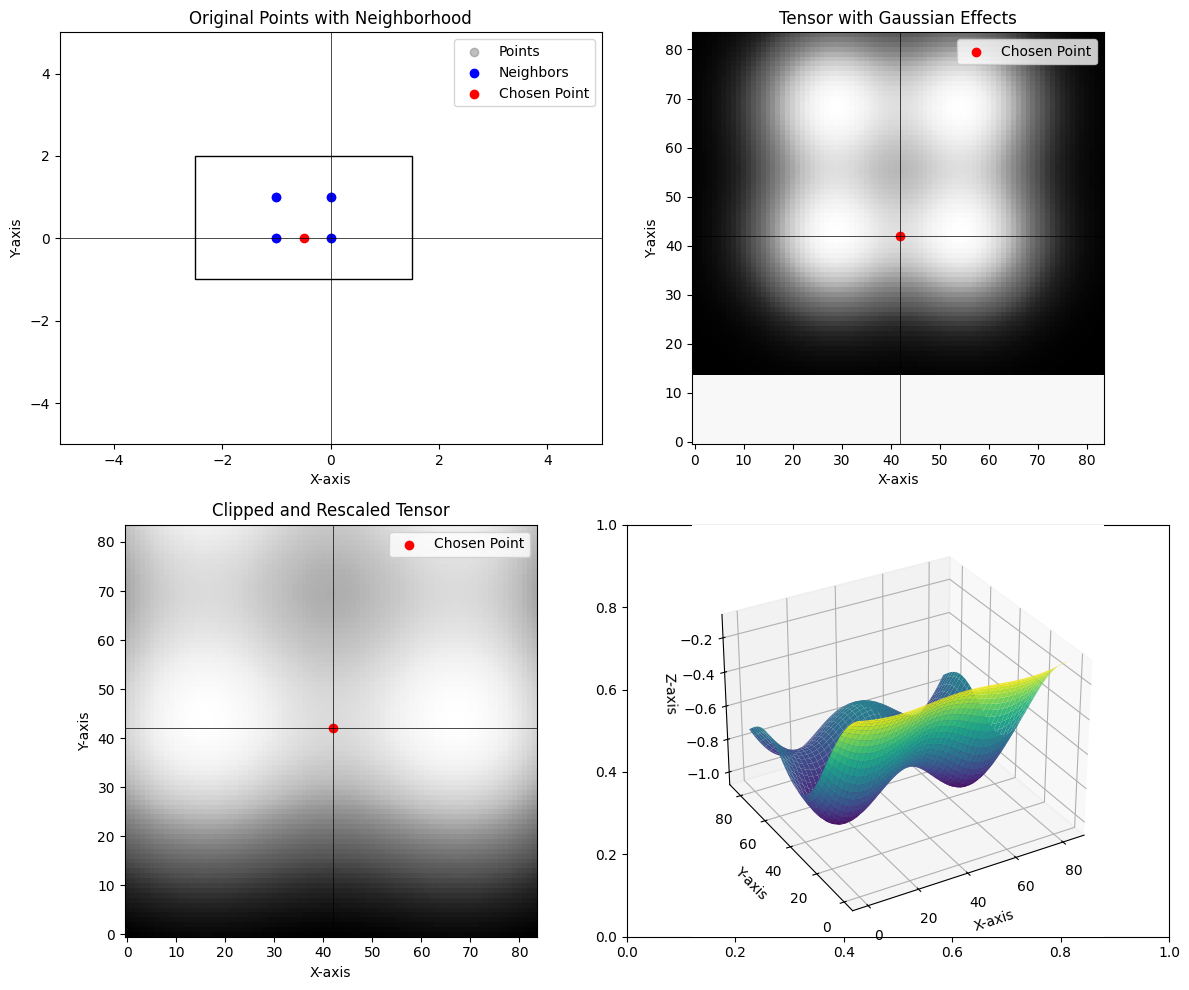

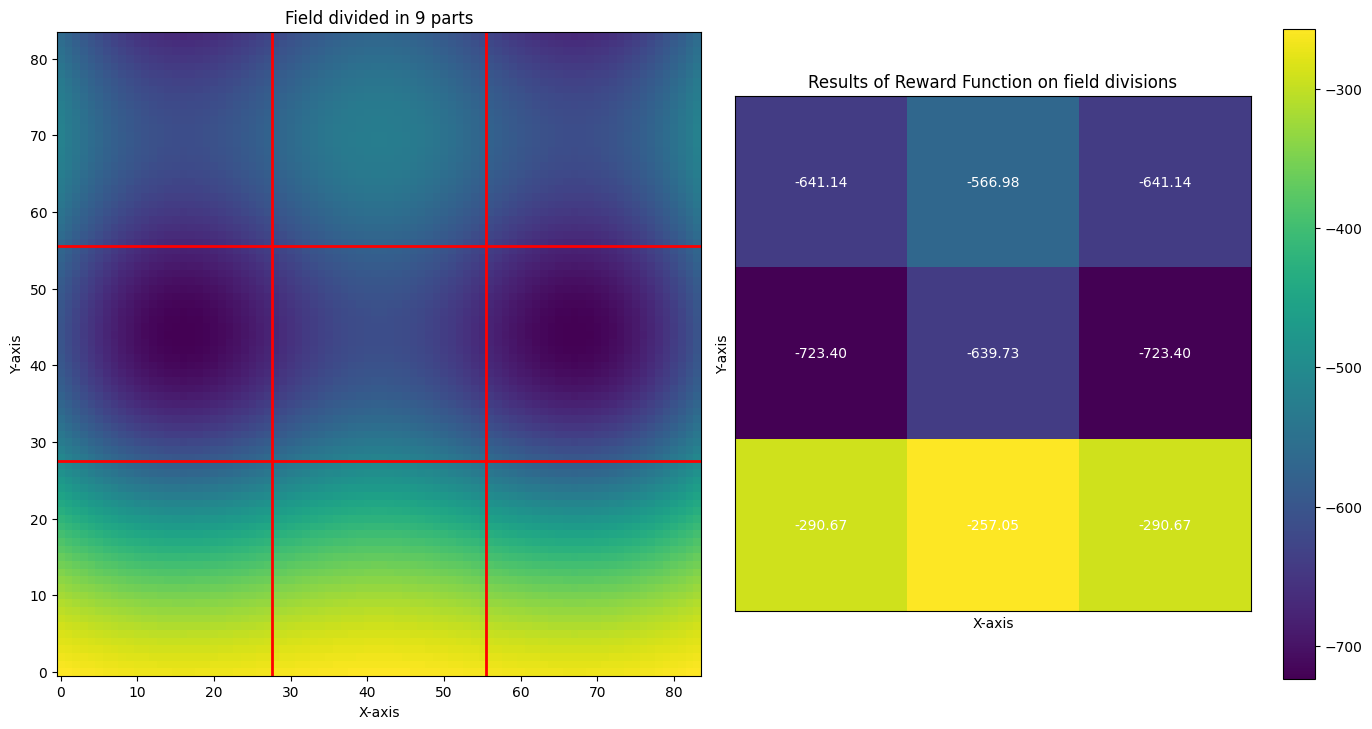

field_divisions [[-290.67141733 -257.05300224 -290.67141733]
 [-723.39933634 -639.73256446 -723.39933634]
 [-641.13601256 -566.98363529 -641.13601256]]


In [7]:
run_field_modulation_scenario(
    points=np.array([[-1, 1], [0, 1], [0, 0], [-1, 0]]),
    center=[-0.5, 0]
)

## Rotating gaussians

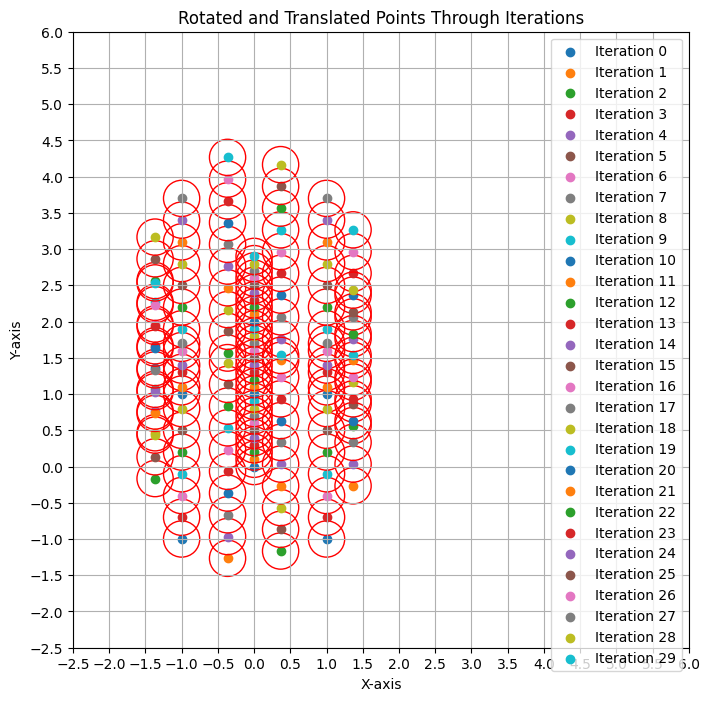

In [8]:
def translate_points(points, translation_vector):
    # Translate each point by the translation vector
    translated_points = points + translation_vector

    return translated_points

# Define the points
points = np.array([[0, 0], [1, 1], [-1, 1], [1, -1], [-1, -1]])

# Define the rotation angle in degrees, the number of iterations, and the translation vector
theta = 30  # Rotation angle
iterations = 30  # Number of iterations
translation_vector = np.array([0, 0.1])  # Translation vector

# Plot the points for each iteration
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(iterations):
    rotated_points = field_modulation.rotate_points(
        points=points, center=[0, 0], theta=theta * i
    )
    translated_points = translate_points(
        rotated_points, translation_vector * i
    )
    ax.scatter(translated_points[:, 0], translated_points[:, 1], label=f"Iteration {i}")
    for point in translated_points:
        ellipse = plt.Circle((point[0], point[1]), 0.25, edgecolor="r", fc="None", lw=1)
        ax.add_patch(ellipse)

# Set plot limits
ax.set_xlim(-2.5, 6)
ax.set_ylim(-2.5, 6)
ax.set_xticks(np.arange(-2.5, 6.5, 0.5))
ax.set_yticks(np.arange(-2.5, 6.5, 0.5))
ax.grid(True)
ax.set_aspect("equal")

# Add legend and labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Rotated and Translated Points Through Iterations")
plt.legend()
plt.show()